In [2]:
import sys
from pathlib import Path

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import metobs_toolkit
print(metobs_toolkit.__version__)

/home/thoverga/anaconda3/envs/metobs_dev/lib/python3.12/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


0.4.1


# Verification pipeline CS-MASK

Put all data (observations, archivedir, metadata, templates etc) in a singel folder (use soft link for archivedir of model)

In [3]:
datafolder = Path("/home/thoverga/Documents/CSMASK/verif/data")

## Importing observations



In [4]:
#Set Paths to files

#TESTDATA:
obsdatafile = datafolder.joinpath('mini_test_vlinder_obs.csv')
metadatafile = metobs_toolkit.demo_metadatafile
templatefile = metobs_toolkit.demo_template


#BIGDATA
obsdatafile = datafolder.joinpath('data_all_cs_stations.csv')
metadatafile = datafolder.joinpath('metadata_all_cs_stations.csv')
templatefile = datafolder.joinpath('csmask_template.json')




In [5]:
dataset = metobs_toolkit.Dataset()
dataset.import_data_from_file(
                    template_file=templatefile,
                    input_data_file=obsdatafile,
                    input_metadata_file=metadatafile,
                    )


The following columns are found in the metadata, but not in the template and are therefore ignored: 
['LCZ']
The following metadata columns are renamed because of special meaning by the toolkit: {'LCZ': 'LCZ_original'}
Station Leuven.cool_109_Leuven_Naamsestraat-Noord is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_110_Leuven_Van_Even is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_111_Leuven_Blijde_Inkomststraat is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_112_Leuven_Stadspark is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_113_Leuven_Damiaanplein is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_114_Leuven_Stadspark is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_116_Leuven_Noormannen is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_117_Leuven_Centrum is skipped because it has only 1 (is < 3) records.
Station Leuven.cool_118_

### metadata

Extract extra metadata to serve as aggregation class for verification.

In [34]:
dataset.get_LCZ()

RefreshError: ('invalid_grant: Token has been expired or revoked.', {'error': 'invalid_grant', 'error_description': 'Token has been expired or revoked.'})

### Apply syncronization

In [6]:
#Coarsen if needed
dataset.resample(target_freq='1h')

### Apply QC 

In [7]:
target = 'temp'


#1. gross value check
dataset.gross_value_check(
            target_obstype=target,
            lower_threshold=-10.0,
            upper_threshold=42.0)

#2. persistence check
# dataset.persistence_check(
#             target_obstype=target,
#             timewindow='4h',
#             min_records_per_window=3)

#3. repetitions check
dataset.repetitions_check(
            target_obstype=target,
            max_N_repetitions=5
)

#4. repetitions check
# dataset.step_check(
#             target_obstype=target,
#             max_increase_per_second = 8.0 / 3600.0, #depends on standard unit!
#             max_decrease_per_second = -10.0 / 3600.0) #depends on standard unit!


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/qc_collection/repetitions_check.py:62: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  groups.get_group(
/home/thoverga/Documen

### Apply GF

### Inspect the data


                            General info of Dataset                             


--- Observational info ---

Dataset instance with:
  -41 number of stations
  -15744 number of records
  -4 types of sensor data are present.
  -Observations from 2020-08-01 00:00:00+00:00 -> 2020-08-01 00:00:00+00:00
  -Outlier info:
    -A total of {outldf.shape[0]} outliers are present.
      -label counts:
        -repetitions outlier: 280
    -For these obstyes: ['temp']
    -For 5 stations: ['vlinder13', 'vlinder16', 'vlinder34', 'vlinder37', 'vl...
  -Gaps info:
    -No gaps present.

--- Metadata info ---

  -41 number of stations
  -The following metadata is present: ['lat', 'lon', 'LCZ', 'school', 'geomet...

--- Modeldata info ---

  -Dataset instance without modeldata.



<Axes: title={'center': 'temp data.'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

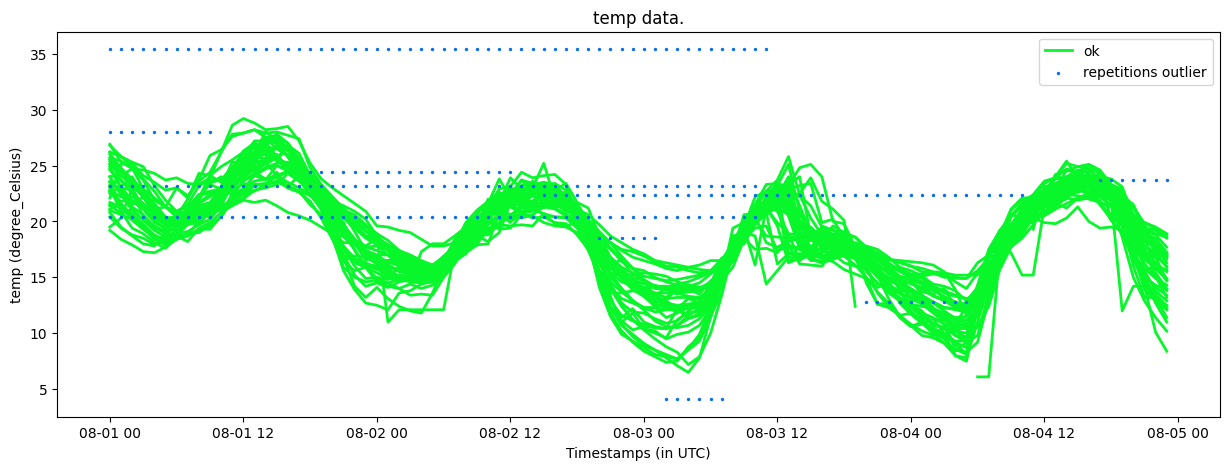

In [8]:
dataset.get_info()
dataset.make_plot(obstype = 'temp', colorby='label')

## Import model output

Note: ERA5 data can be extracted directly from the datataset, then skip this section.

In [6]:
modelid = "AromeCy48t3_belgium_1.4"
variable_def=metobs_toolkit.default_SFX_fields

#SUbset to one field for memory saving
variable_def = [variable_def[0]]
variable_def


[ModelObstype instance of temp]

In [7]:
def load_all_netcdf_files(folder: Path, fileglobstr="*.nc", **kwargs) -> xr.Dataset:
    if not folder.is_dir():
        raise NotADirectoryError(f"{folder} is not a directory")
    files = sorted([str(f) for f in folder.glob(fileglobstr) if f.is_file()])
    if not files:
        raise FileNotFoundError(f"No NetCDF files found in {folder}")
    return xr.open_mfdataset(files, combine='by_coords', **kwargs)

def load_netcdf_file(file_path: Path, **kwargs) -> xr.Dataset:
    if not file_path.is_file():
        raise FileNotFoundError(f"{file_path} does not exist or is not a file")
    return xr.open_dataset(str(file_path), **kwargs)


In [8]:
#FYI, this step took about 17 minutes for the 1.3km domain

modeldataset = load_all_netcdf_files(datafolder,
                                    fileglobstr="belgium13_run_archive/*/*/*/00/*.sfx.nc", engine='netcdf4')
mod = metobs_toolkit.ModelDataset(
                        modelID=modelid,
                        dataset=modeldataset,
                        field_defenitions=variable_def)


The following variables are unmapped and are removed from the modeldataset: ['SFX.MER10M', 'SFX.Q2M_TEB', 'SFX.ZON10M', 'SFX.Q2M', 'SFX.Q2M_ISBA', 'SFX.T2M', 'SFX.T2M_TEB', 'SFX.H', 'SFX.RN']


SFX.T2M_ISBA


In [9]:
mod


Gridded output of AromeCy48t3_belgium_1.4:
 <xarray.Dataset> Size: 28GB
Dimensions:         (reference_time: 31, validtime: 755, y: 364, x: 412,
                     level: 90)
Coordinates:
  * x               (x) int64 3kB 0 1 2 3 4 5 6 ... 405 406 407 408 409 410 411
  * level           (level) int64 720B 1 2 3 4 5 6 7 8 ... 84 85 86 87 88 89 90
  * y               (y) int64 3kB 363 362 361 360 359 358 357 ... 6 5 4 3 2 1 0
  * validtime       (validtime) datetime64[ns] 6kB 2020-08-01 ... 2020-09-01T...
  * reference_time  (reference_time) datetime64[ns] 248B 2020-08-01 ... 2020-...
    lon             (x, y) float64 1MB dask.array<chunksize=(412, 364), meta=np.ndarray>
    lat             (x, y) float64 1MB dask.array<chunksize=(412, 364), meta=np.ndarray>
Data variables:
    SFX.T2M_ISBA    (reference_time, validtime, y, x) float64 28GB dask.array<chunksize=(1, 1, 364, 412), meta=np.ndarray>
Attributes: (12/47)
    CADRE-DIMENSIONS:     [ 191  384  432   90 -215]
    CADRE-FRANKSCH

## Filter: Towards 1D in time

The modeloutput has two time dimensions (*validtime* and *refernce_time*), and span 2-dimensions. In order to go to a single time dimension the output must be filtered by:

* Removing spinup periods for each cycle
* Remove overlapping tails (=were cycles overlap). Here we apply the *use_newest_cycle* protocol for handling the duplicates.

As a result we have reduce the time-span to 1D, HOWEVER the two time dimensions are still present! 


In [10]:
spinup = '6h'

#1: drop spinup periods
mod.trim_spinup_period(spinup_duration=spinup, drop=True)





In [11]:
#2: trim_tails
mod.trim_tails_of_cycled_ds(keep_smallest_lt=True) #SPINUP MUST BE REMOVED BEFORE !!

mod


: 

### Plot spatial


## Clip spatial data to timeseries

The goal is that the spatial modeloutput is converted to timeseries at the stations locations. This is done by importing the modeldata to the (observational) dataset.


In [14]:
dataset.get_NWP_timeseries_data(modeldataset=mod)

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset.py:1397: UserWarning: No timeseries could be extracted for Station instance of vlinder29, it has not coordinates!Skipped
  warnings.warn(f'No timeseries could be extracted for {sta}, it has not coordinates!Skipped')
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset.py:1397: UserWarning: No timeseries could be extracted for Station instance of vlinder30, it has not coordinates!Skipped
  warnings.warn(f'No timeseries could be extracted for {sta}, it has not coordinates!Skipped')
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset.py:1397: UserWarning: No timeseries could be extracted for Station instance of vlinder31, it has not coordinates!Skipped
  warnings.warn(f'No timeseries could be extracted for {sta}, it has not coordinates!Skipped')
/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/dataset.py:1397: UserWarning: No timeseries coul

In [ ]:
#Save the dataset
trg_file = datafolder.joinpath(f"dataset_with_{modelid}.pkl")

dataset.save_dataset_to_pkl(target_folder=str(datafolder),
                            filename=f"dataset_with_{modelid}.pkl")

## Set a target 

In the following, if we refer to modeldata we must be precise by what we mean by that. So if we specify modeldata, we must specify which obstype (Modelobstype), from wich model (modelID), and the target band (modelband). 

To define the target at one place, we put it in a dict and unfold it method calls.

In [15]:
target_def =  {
    'target_obstype': 'temp', 
    'trg_modelID': 'AromeCy48t3_belgium_1.4',
    'trg_bandname': 'SFX.T2M_ISBA',
    }
    

### (Optional) era5 as modeldata

In [16]:
era5_manager = metobs_toolkit.default_GEE_datasets["ERA5-land"]

# era5_data = dataset.get_gee_timeseries_data(
#     geedynamicdatasetmanager=era5_manager,
#     startdt_utc=None,  # raises error in metadata-only case
#     enddt_utc=None,
#     target_obstypes=["temp"],
#     get_all_bands=False,
#     drive_filename=None,
#     # drive_folder="gee_timeseries_data",
#     force_direct_transfer=False,
#     force_to_drive=False,
# )


dataset.import_gee_data_from_file(filepath="/home/thoverga/Downloads/ERA5-land_vlinders_demo.csv",
                                  geedynamicdatasetmanager=era5_manager)



temp     pressure
name      datetime                                         
vlinder01 2022-09-01 00:00:00+00:00  18.394525  1017.902695
          2022-09-01 01:00:00+00:00  17.799753  1017.461797
          2022-09-01 02:00:00+00:00  17.415353  1017.439766
          2022-09-01 03:00:00+00:00  16.820734  1017.180352
          2022-09-01 04:00:00+00:00  16.450281  1016.983633
...                                        ...          ...
vlinder28 2022-09-15 20:00:00+00:00  14.408151  1010.590937
          2022-09-15 21:00:00+00:00  13.831171  1010.626992
          2022-09-15 22:00:00+00:00  13.174661  1011.179062
          2022-09-15 23:00:00+00:00  12.936517  1010.934922
          2022-09-16 00:00:00+00:00  12.735727  1010.891836

[10108 rows x 2 columns]

### timeseries plots



<Axes: title={'center': 'temp data for station vlinder05'}, xlabel='Timestamps (in UTC)', ylabel='temp (degree_Celsius)'>

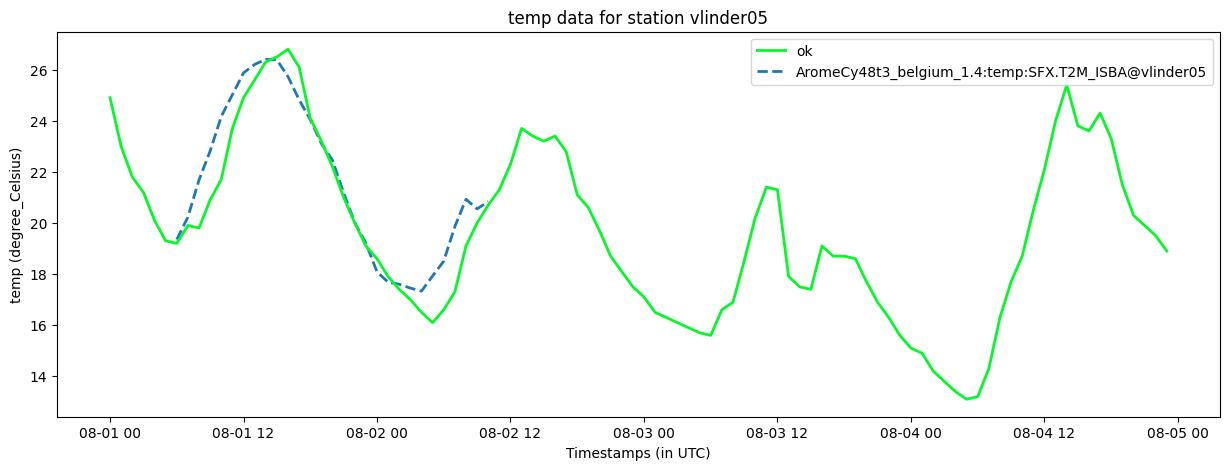

In [17]:
dataset.get_station('vlinder05').make_plot( obstype='temp',
                                           show_modeldata=True,
                                           trg_model_bandname=target_def['trg_bandname'],
                                           trg_modelID=target_def['trg_modelID'],
                                            )


# Verification

Verification is handled by the `metobs_toolkit.Verification` class. In pracktice, this is just a wrapper on the Dataset/Station class. But this id done so to keep it in parallel of these classes, rather than adjusting these classes.

In [18]:
shift_tolerance = pd.Timedelta('5min')


In [19]:

ver = metobs_toolkit.Verification(obj=dataset)
verifdf = ver._create_verifdf(**target_def,
                              shift_tolerance=shift_tolerance)
verifdf


fc  observation
datetime                  name                             
2020-08-01 06:00:00+00:00 vlinder01  19.732954    18.600000
                          vlinder02  19.471977    19.200001
                          vlinder03  21.990944    20.700001
                          vlinder04  21.909050    19.799999
                          vlinder05  19.351362    19.200001
...                                        ...          ...
2020-08-02 10:00:00+00:00 vlinder24  19.828970    19.100000
                          vlinder25  20.290794    19.400000
                          vlinder26  22.024679    19.700001
                          vlinder27  20.645405    21.799999
                          vlinder28  21.791809    20.900000

[754 rows x 2 columns]

## Intermezzo: styling defenitions

Section on styling defenitions for plots.


In [20]:
#Use a lcz color map representing neir-types with neir-colors

#Reuse the lcz color scheme from Metobs
lcz_manager = metobs_toolkit.default_GEE_datasets['LCZ']
lcz_col_map = {lcz_manager.class_map[i]: lcz_manager.col_scheme[i] for i in lcz_manager.class_map.keys()}
lcz_col_map

{'Compact highrise': '#8c0000',
 'Compact midrise': '#d10000',
 'Compact lowrise': '#ff0000',
 'Open highrise': '#bf4d00',
 'Open midrise': '#ff6600',
 'Open lowrise': '#ff9955',
 'Lightweight lowrise': '#faee05',
 'Large lowrise': '#bcbcbc',
 'Sparsely built': '#ffccaa',
 'Heavy industry': '#555555',
 'Dense Trees (LCZ A)': '#006a00',
 'Scattered Trees (LCZ B)': '#00aa00',
 'Bush, scrub (LCZ C)': '#648525',
 'Low plants (LCZ D)': '#b9db79',
 'Bare rock or paved (LCZ E)': '#000000',
 'Bare soil or sand (LCZ F)': '#fbf7ae',
 'Water (LCZ G)': '#6a6aff'}

## Verification: values

Verification results of values (and differnces with refernces).



(<Axes: title={'center': 'Timeseries of temp (obs & fc)\n (originates from SFX.T2M_ISBA)'}, ylabel='temp (degree_Celsius)'>,
 <Axes: title={'center': 'Residuals'}, ylabel='fc - obs (in degree_Celsius)'>)

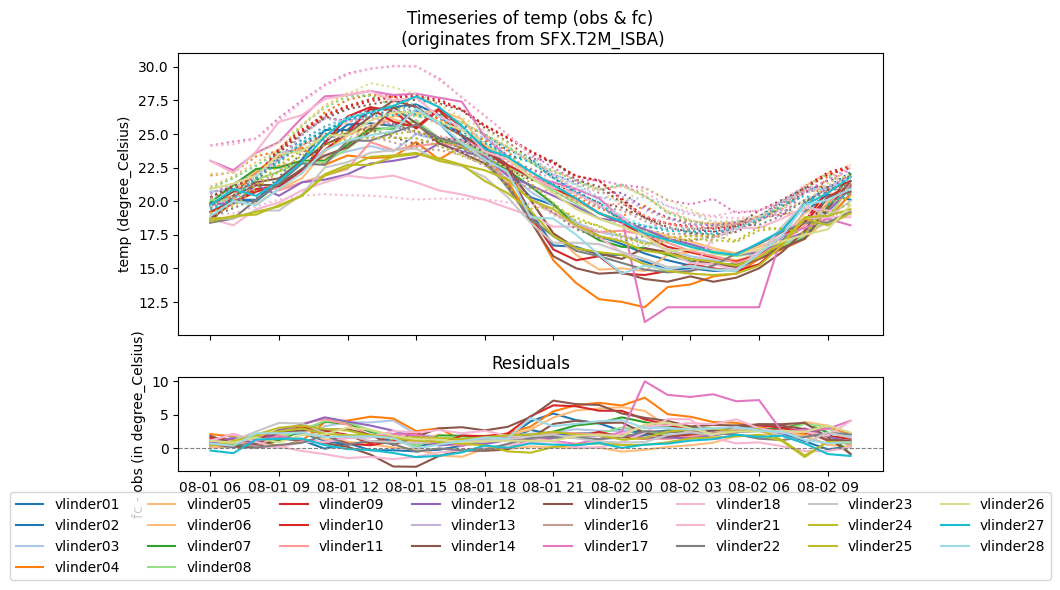

In [21]:
ver.plot_timeseries_of_obs_and_fc(**target_def)
                                  

### Temperatures aggregated


<Axes: title={'center': 'ModelObstype instance of temp forecasted values grouped per name.'}, xlabel='hour', ylabel='temp (degree_Celsius))'>

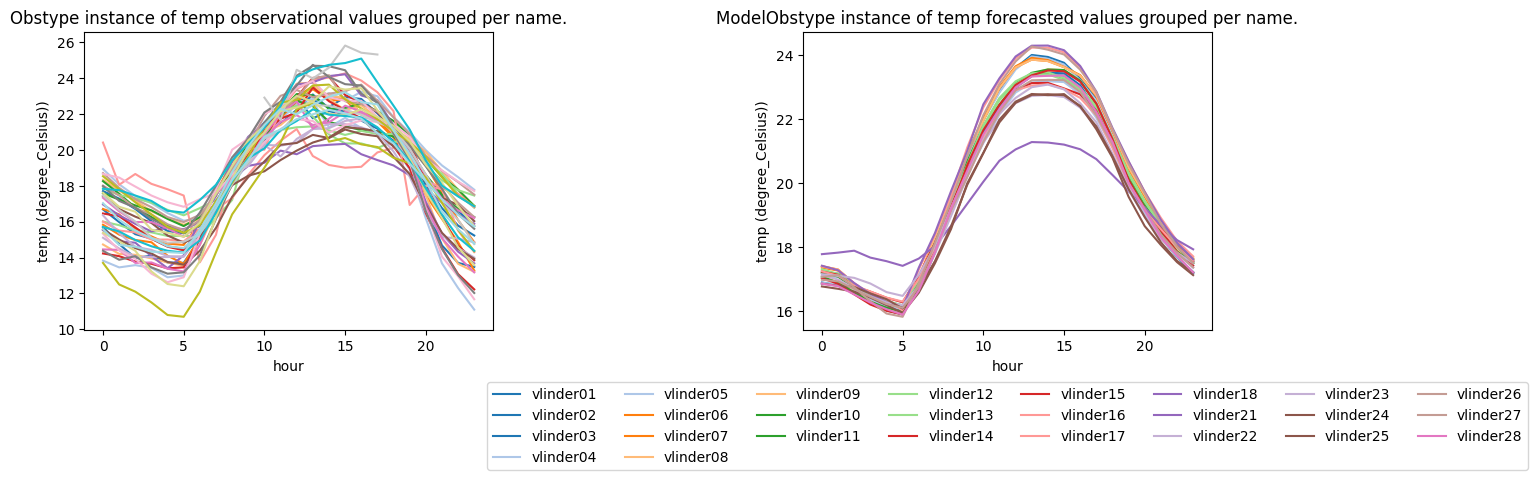

In [22]:
import metobs_toolkit.plot_collection as plotting

#make two panels (left -> observations, right -> fc)
fig, (ax0, ax1) = plt.subplots(figsize=(15,5), ncols=2)
#Make sure the same colorscheme is used.
colorby='name'
colmap = plotting.create_categorical_color_map(catlist = ver.obj.metadf.reset_index()[colorby])


ver.plot_value_cycles(**target_def,
                      reference_station=None, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax0,
                      output_is_obs = True)
ax0.get_legend().remove() #is set by the ax1


ver.plot_value_cycles(**target_def,
                      reference_station=None, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax1,
                      output_is_obs = False)


<Axes: title={'center': 'ModelObstype instance of temp forecasted differences with vlinder02, grouped per LCZ.'}, xlabel='hour', ylabel='temp (degree_Celsius))'>

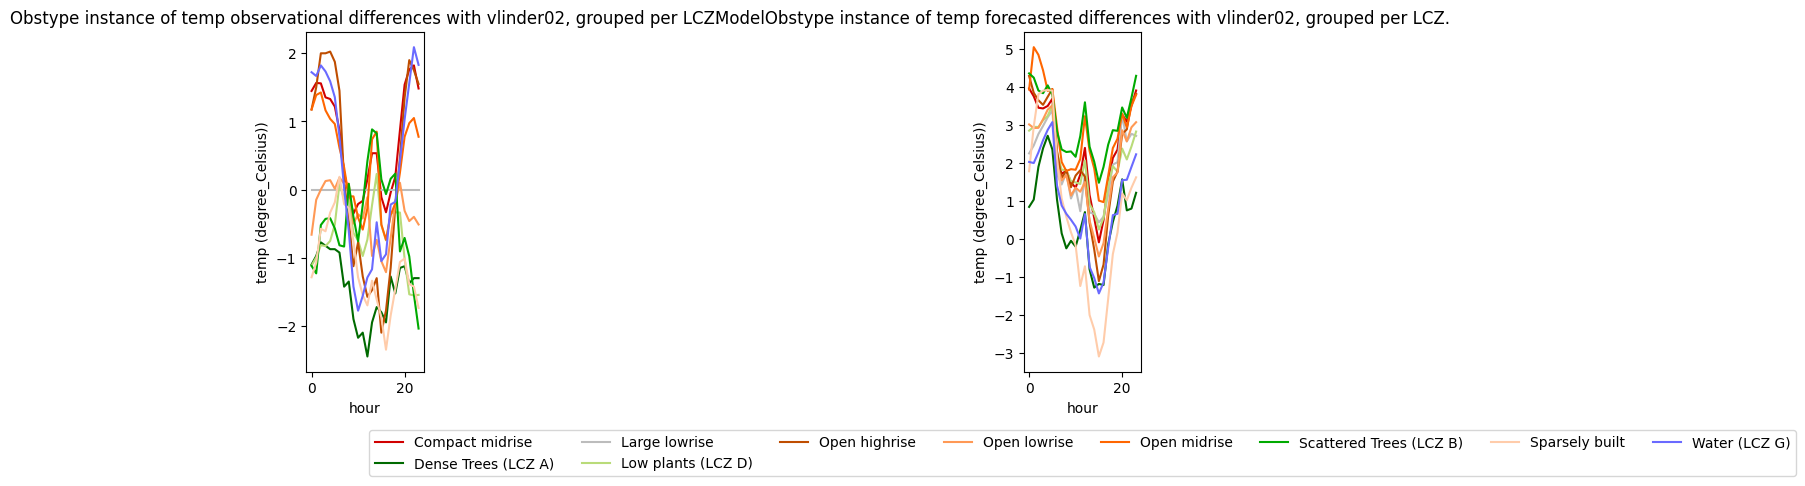

In [23]:
refstation = 'vlinder02'


#make two panels (left -> observations, right -> fc)
fig, (ax0, ax1) = plt.subplots(figsize=(15,5), ncols=2)
#Make sure the same colorscheme is used.
colorby='LCZ'
if colorby == 'LCZ':
    colmap = lcz_col_map
else:
    colmap = plotting.create_categorical_color_map(catlist = ver.obj.metadf.reset_index()[colorby])


ver.plot_value_cycles(**target_def,
                      reference_station=refstation, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax0,
                      output_is_obs = True)
ax0.get_legend().remove() #is set by the ax1


ver.plot_value_cycles(**target_def,
                      reference_station=refstation, 
                      colorby=colorby,
                      xaxis='hour',
                      colmap=colmap,
                      ax=ax1,
                      output_is_obs = False)

## Verification : scores
### Aggregationgroups


In [24]:
agg_scores_group = ['datetime'] #Include all levels needed for the plot
xax_lvl = 'datetime'
colorlvl = None
to_plot_value= None #If None, all values related to the to plot level are presented ()
to_plot_lvl = 'score'

In [25]:
scoringdf = ver.get_scoring_df(
            **target_def,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)
print(scoringdf.head())

datetime                   score     
2020-08-01 06:00:00+00:00  rmse           1.021396
                           mae            0.891404
                           bias           0.863222
                           samplesize    24.000000
2020-08-01 07:00:00+00:00  rmse           1.137490
Name: value, dtype: float64


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:182: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score and datetime.'}, xlabel='datetime'>

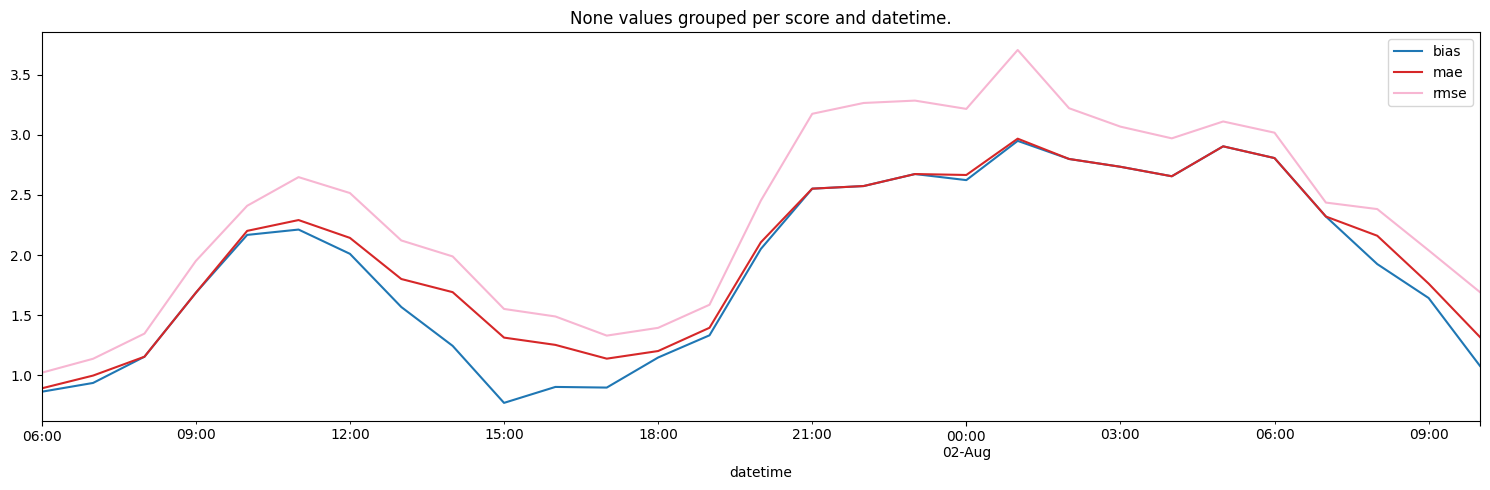

In [26]:
#Make plot

#Optional: filter out scores with other 'units' 
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

ver.plot_scoring(scoringdf=scoringdf,
                 xaxis_level=xax_lvl,
                 color_level=colorlvl,
                to_plot_value=to_plot_value,
                to_plot_level=to_plot_lvl)

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:182: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score and name.'}, xlabel='name'>

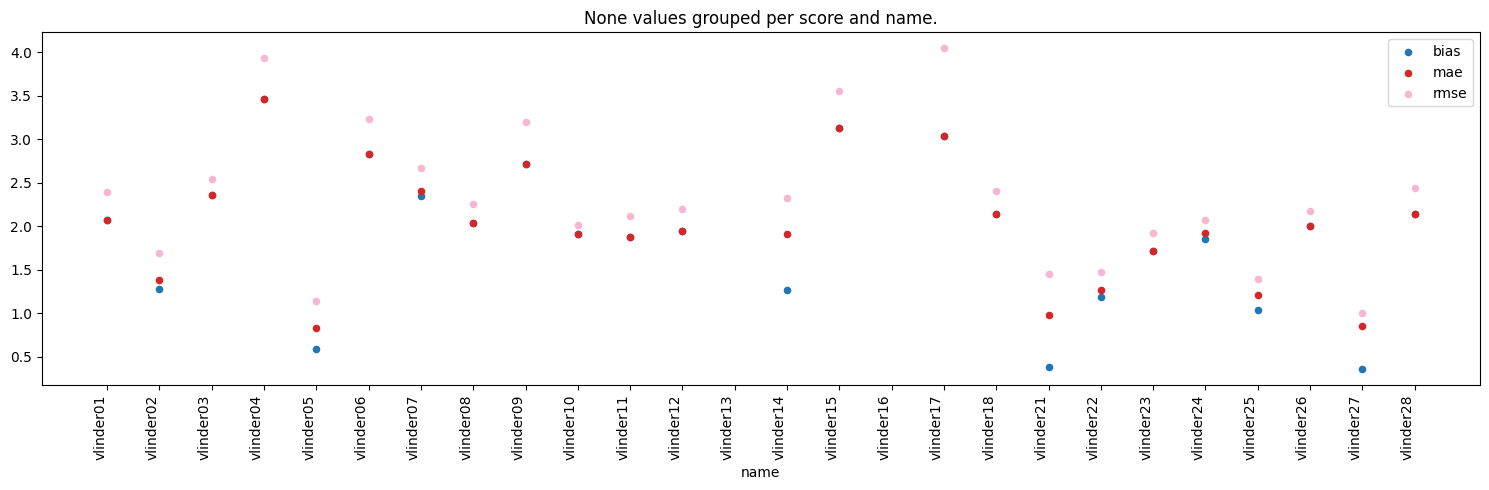

In [27]:
# aggregated to stationnames
agg_scores_group = ['name'] #Include all levels needed for the plot
xax_lvl = 'name'
colorlvl = None
to_plot_value= None
to_plot_lvl = 'score'

scoringdf = ver.get_scoring_df(
            **target_def,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

ver.plot_scoring(scoringdf=scoringdf,
                 xaxis_level=xax_lvl,
                 color_level=colorlvl,
                to_plot_value=to_plot_value,
                to_plot_level=to_plot_lvl)

### Diurnal aggregation

In this section we make compute diurnal scores and plots.


/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:182: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'rmse values grouped per LCZ and hour.'}, xlabel='hour', ylabel='rmse'>

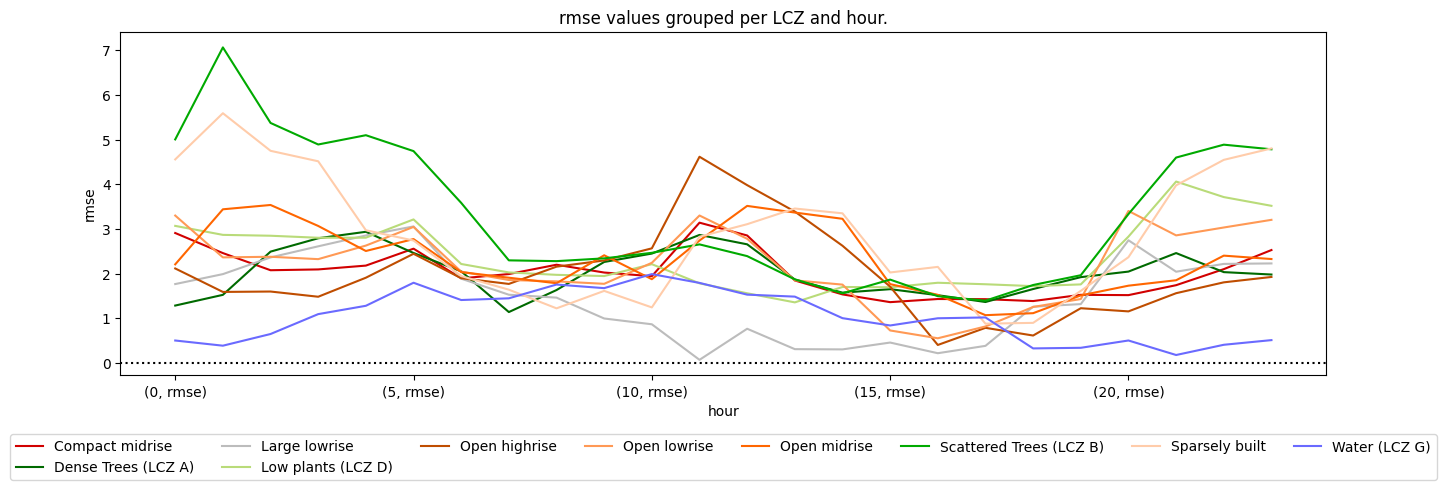

In [28]:
agg_scores_group = ['hour', 'LCZ'] #hour makes it diurnal !! 
xax_lvl = 'hour'
colorlvl = 'LCZ'
to_plot_value= 'rmse' 
to_plot_lvl = 'score'

colmap = lcz_col_map
# colmap = None


#Compute scores
scoringdf = ver.get_scoring_df(
            **target_def,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

#Drop samplesizes
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

#plot
ver.plot_scoring(
        scoringdf=scoringdf,
        xaxis_level=xax_lvl,
        color_level=colorlvl,
        to_plot_value=to_plot_value,
        to_plot_level=to_plot_lvl,
        colmap=colmap,
        draw_h_line_at=0)

/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/verification.py:182: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(dropna=False)


<Axes: title={'center': 'None values grouped per score and hour.'}, xlabel='hour'>

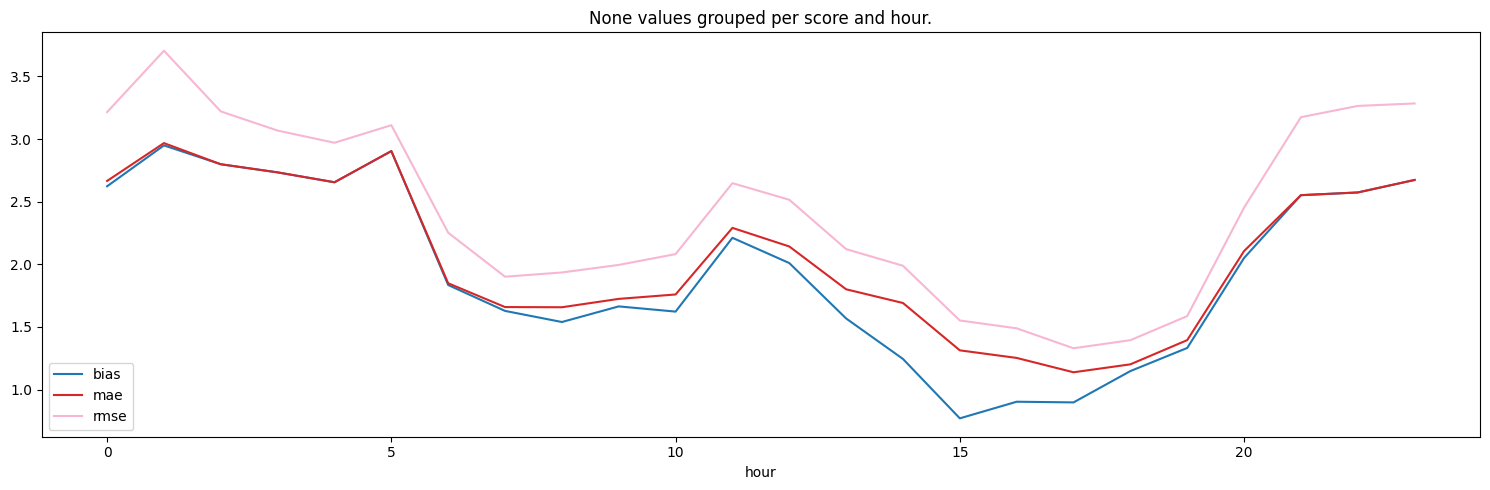

In [29]:
agg_scores_group = ['hour'] #hour makes it diurnal !! 
xax_lvl = 'hour'
colorlvl = 'score'
to_plot_value= None # thus all scores under the 'score' lvel
to_plot_lvl = 'score'


#Compute scores
scoringdf = ver.get_scoring_df(
            **target_def,
            groupby=agg_scores_group,
            shift_tolerance=shift_tolerance)

#Drop samplesizes
blackscores = ['samplesize'] 
scoringdf = scoringdf[~scoringdf.index.get_level_values('score').isin(blackscores)]

#plot
ver.plot_scoring(
        scoringdf=scoringdf,
        xaxis_level=xax_lvl,
        color_level=colorlvl,
        to_plot_value=to_plot_value,
        to_plot_level=to_plot_lvl)